# Open Data Science Theme #3. Decision Trees

Разбор урока на Хабр: https://habr.com/ru/company/ods/blog/322534/
---

In [1]:
# from __future__ import division, print_function
# # отключим всякие предупреждения Anaconda
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#Код для генерации данных
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

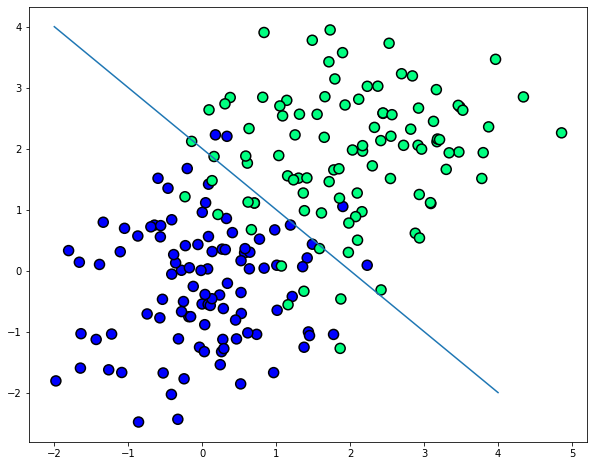

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='winter', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

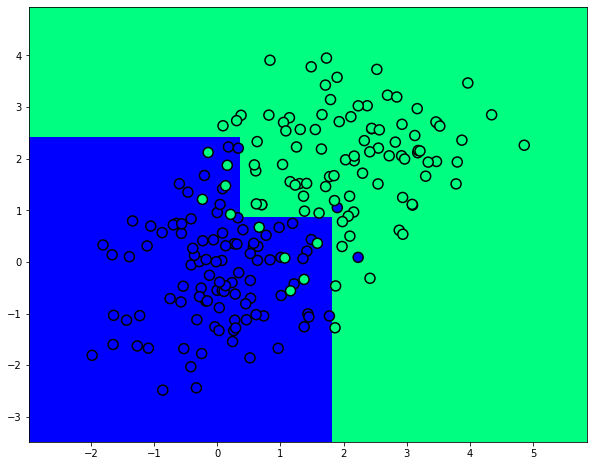

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='winter')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='winter', edgecolors='black', linewidth=1.5);

In [5]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

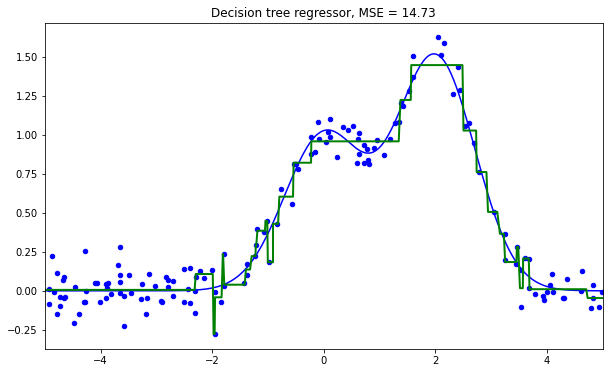

In [6]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

**Decision Tree & kNN**

In [7]:
df = pd.read_csv('telecom_churn.csv')

df['international plan'] = pd.factorize(df['international plan'])[0]
df['voice mail plan'] = pd.factorize(df['voice mail plan'])[0]
df['churn'] = df['churn'].astype('int')
states = df['state']
y = df['churn']
df.drop(['state', 'churn', 'phone number'], axis=1, inplace=True)

In [8]:
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [10]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred) 

0.94

In [11]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(1,11),
'max_features': range(4,19)}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_fea

In [13]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [14]:
tree_grid.best_score_

0.94257014456259

In [15]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1,
                        verbose=True)

knn_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [18]:
knn_grid.best_params_

{'knn__n_neighbors': 7}

In [19]:
knn_grid.best_score_

0.8859867109023905

In [20]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5))) # 0.949

forest_params = {'max_depth': range(1,11),
                 'max_features': range(4,19)}

forest_grid = GridSearchCV(forest, forest_params,
                           cv=5, n_jobs=-1,verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_

0.9494233119813256
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  6.0min finished


({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [22]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

In [23]:
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
out_file='churn_tree.dot', filled=True)
!dot -Tpng 'churn_tree.dot' -o 'img/churn_tree.png'

Error: Could not open "img/churn_tree.png" for writing : No such file or directory


In [26]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [27]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
axes[i].imshow(X[i,:].reshape([8,8]));

IndentationError: ignored

In [28]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=17)

In [29]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.9740740740740741, 0.6666666666666666)

In [30]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 492 out of 495 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    2.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
     

In [31]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [32]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.9864858028204642

In [33]:
np.mean(cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5))

0.9753462341111744